## Goal:

Here we test the functions: `lbfgsb` in the `Screenkhorn` class.

In [1]:
# NUMPY
import numpy as np
np.random.seed(3946)
# MATPLOTLIB
import matplotlib.pyplot as plt
plt.style.context('dark_background')
%matplotlib inline 
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 8, # 12
          'font.size': 8, # 12
          'legend.fontsize': 8, # 12
          'xtick.labelsize': 8, # 10
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (16, 6)}
plt.rcParams.update(params)

# SEABORN 
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

# SKLEARN 
from sklearn.metrics import pairwise_distances

# WARNINGS
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# TIME
from time import time 

# PATH 
import sys
path_files = '/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/'
sys.path.insert(0, path_files) 


# POT
import ot
from ot import sinkhorn, emd

# GREENKHORN 
from ot.bregman import greenkhorn

# SCREENKHORN
from screenkhorn.base import Screenkhorn


## Data generation

In [2]:
n_1 = 10000# nb samples
n_2 = 10000
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n_1, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n_2, mu_t, cov_t)

# a = np.ones((n_1,)) / n_1
# b = np.ones((n_2,)) / n_2  # uniform distribution on samples

a = abs(np.random.normal(size=(n_1,)))
b = abs(np.random.normal(size=(n_2,)))

a = a / a.sum()
b = b / b.sum()

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()
reg = 0.09
K = np.exp(-M/reg)

In [3]:
lower_bound_epsilon = M.max()/806
lower_bound_epsilon

0.0012406947890818859

## Sinkhorn 

In [32]:
tic = time()
P_sink = sinkhorn(a, b, M, reg, log=True)
P_star = P_sink[0]
outputs_dict = P_sink[1]
exp_u_star = outputs_dict['u']
exp_v_star = outputs_dict['v']
time_sink = time() - tic
print("time of Sinkhorn algorithm is %s" %time_sink)

time of Sinkhorn algorithm is 2.986715078353882


## Bounds of $\varepsilon \in (\varepsilon_{\min}, \varepsilon_{\max})$


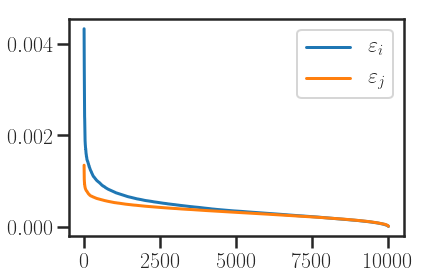

In [5]:
epsilons_a = np.sqrt(a / K.sum(axis=1))
epsilons_a_sort = np.sort(epsilons_a)[::-1]
epsilons_b = np.sqrt(b / K.T.sum(axis=1))
epsilons_b_sort = np.sort(epsilons_b)[::-1]
plt.plot(epsilons_a_sort, label=r'$\varepsilon_i$')
plt.plot(epsilons_b_sort, label=r'$\varepsilon_j$')
plt.legend();

#### Choice of epsilon

In [6]:
epsilons_ab = np.sort(np.hstack([epsilons_a, epsilons_b]))[::-1]
epsilon_mid = (max(epsilons_ab) - min(epsilons_ab))/2+ min(epsilons_ab)
epsilon_min = min(epsilons_ab)
epsilon_max = max(epsilons_ab)

epsilon_min, epsilon_mid, epsilon_max

(3.5958974140236994e-06, 0.0021686132820265755, 0.004333630666639127)

In [7]:
# theoretical epsilon_min and epsilon_max
epsilon_min_th = max((np.sqrt(a/K.sum(axis=1))).min(), (np.sqrt(b/K.T.sum(axis=1))).min())
epsilon_max_th = min((np.sqrt(a/K.sum(axis=1))).max(), (np.sqrt(b/K.T.sum(axis=1))).max())

epsilon_min_th, epsilon_max_th

(5.573993658450334e-06, 0.0013449453908209613)

In [8]:
#np.sqrt(b.min()/K.T.sum(axis=1))

In [9]:
# theoretical epsilon_min and epsilon_max
epsilon_min_th2 = min(np.sqrt(a.min()/ (K.sum(axis=1)).max() ), np.sqrt(b.min() / (K.T.sum(axis=1)).max() ))
epsilon_max_th2 = max(np.sqrt(a.max()/ ((K.sum(axis=1)).min())), np.sqrt(b.max()/((K.T.sum(axis=1)).min())))

epsilon_min_th2, epsilon_max_th2

(8.768434711799581e-07, 0.007493897317181899)

In [10]:
epsilon_min_u = a.min()/ (K.sum(axis=1)).max() 
epsilon_max_u = a.max()/ ((K.sum(axis=1)).min())
print(epsilon_min_u, epsilon_max_u)

epsilon_min_v = b.min()/ (K.T.sum(axis=1)).max() 
epsilon_max_v = b.max()/ ((K.T.sum(axis=1)).min())
print(epsilon_min_v, epsilon_max_v)

7.688544729509181e-13 5.615849700046606e-05
1.3640299059771059e-11 4.3756250923666925e-06


In [11]:
epsilon_full_min_u = epsilon_min_u / epsilon_min_v
epsilon_full_max_u = epsilon_max_u / epsilon_max_v

print(epsilon_full_min_u, epsilon_full_max_u)

epsilon_full_min_v = epsilon_min_v / epsilon_min_u
epsilon_full_max_v = epsilon_max_v / epsilon_min_u
print(epsilon_full_min_v, epsilon_full_max_v)


I_full = np.where(a >= epsilon_full_min_u * K.sum(axis=1))[0].tolist()
J_full = np.where(b >= epsilon_full_min_v * K.T.sum(axis=1))[0].tolist()

0.05636639413709619 12.834394129980408
17.741067444686408 5691096.620109047


In [12]:
epsilon_min_a = a.min()/((K.sum(axis=1)).min())
epsilon_max_a = a.max()/((K.sum(axis=1)).min())

epsilon_min_b = b.min()/((K.T.sum(axis=1)).min())
epsilon_max_b = b.max()/((K.T.sum(axis=1)).min())

#, np.sqrt(b.min()/((K.T.sum(axis=1)).min())))
# epsilon_max_th2 = max(np.sqrt(a.max()/((K.sum(axis=1)).min())), np.sqrt(b.max()/((K.T.sum(axis=1)).min())))

epsilon_min_a, epsilon_max_a, epsilon_min_b, epsilon_max_b

(5.59570358369167e-10,
 5.615849700046606e-05,
 3.3902760460225154e-10,
 4.3756250923666925e-06)

In [13]:
## Check the epsilon
epsilon_full = epsilon_max_th2

I_full = np.where(a >= epsilon_full**2 * K.sum(axis=1))[0].tolist()
J_full = np.where(b >= epsilon_full**2 * K.T.sum(axis=1))[0].tolist()

len(I_full), len(J_full)

(0, 0)

In [14]:
epsilon_active = (epsilon_max_th2 - epsilon_min_th2)/17+ epsilon_min_th2
I_active = np.where(a >= epsilon_active**2 * K.sum(axis=1))[0].tolist()

J_active = np.where(b >= epsilon_active**2 * K.T.sum(axis=1))[0].tolist()

len(I_active), len(J_active)

(3448, 2089)

#### Initial points and a priori active sets

In [15]:
u0 = np.full(len(I_active),  1.0)
v0 = np.full(len(J_active), 1.0)

In [16]:
tic = time()
screenkhorn = Screenkhorn(a, b, M, reg, epsilon_active, I_active, J_active)
toc_initial = time() - tic
toc_initial

2.2407679557800293

## L-BFGS-B

In [17]:
tic = time()
screenkhorn = Screenkhorn(a, b, M, reg, epsilon_active, I_active, J_active)
lbfgsb = screenkhorn.lbfgsb(u0, v0)
toc_bfgs = time() - tic
toc_bfgs

Time spending during the restricted Skinkhorn is 0.07621598243713379


5.313608884811401

In [18]:
print("Time of Sinkhorn: %s" %time_sink, '\n')
print("Time of LBFGS inculding the class initialization: %s" %toc_bfgs, '\n')
print("Ratio Time of Sinkhorn / Time of LBFGS: %s" %(time_sink / toc_bfgs),'\n')
print("Ratio Time of LBFGS /Time of Sinkhorn : %s" %( toc_bfgs / time_sink))

Time of Sinkhorn: 7.5567522048950195 

Time of LBFGS inculding the class initialization: 5.313608884811401 

Ratio Time of Sinkhorn / Time of LBFGS: 1.422150626572365 

Ratio Time of LBFGS /Time of Sinkhorn : 0.7031603975805132


In [19]:
tic = time()
lbfgsb = screenkhorn.lbfgsb(u0, v0)
toc_bfgs = time() - tic
toc_bfgs

Time spending during the restricted Skinkhorn is 0.06604719161987305


0.16404008865356445

In [20]:
print("Time of Sinkhorn: %s" %time_sink, '\n')
print("Time of LBFGS without class initialization: %s" %toc_bfgs, '\n')
print("Ratio Time of Sinkhorn / Time of LBFGS: %s" %(time_sink / toc_bfgs), '\n')
print("Ratio Time of LBFGS /Time of Sinkhorn : %s" %( toc_bfgs / time_sink))

Time of Sinkhorn: 7.5567522048950195 

Time of LBFGS without class initialization: 0.16404008865356445 

Ratio Time of Sinkhorn / Time of LBFGS: 46.06649671382519 

Ratio Time of LBFGS /Time of Sinkhorn : 0.021707750129388203


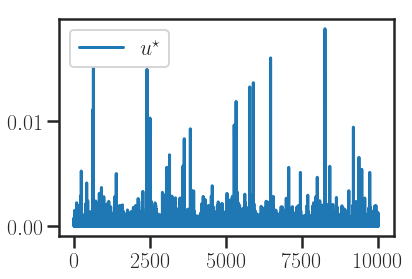

In [21]:
plt.plot(exp_u_star, label=r'$u^\star$')
plt.legend();

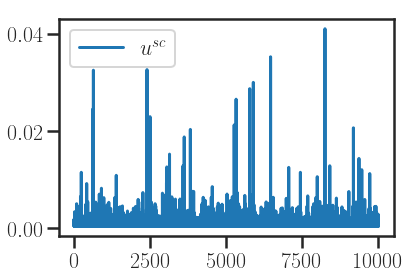

In [22]:
plt.plot(lbfgsb[0], label=r'$u^{sc}$')
plt.legend();

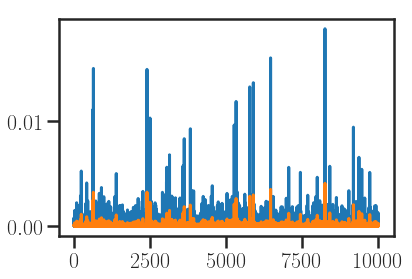

In [24]:
plt.plot(exp_u_star)
plt.plot(lbfgsb[0]/1e1);

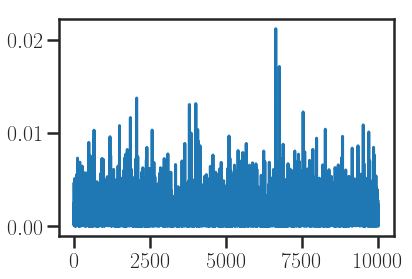

In [25]:
plt.plot(exp_v_star);

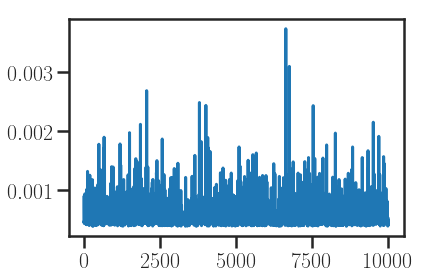

In [26]:
plt.plot(lbfgsb[1]);

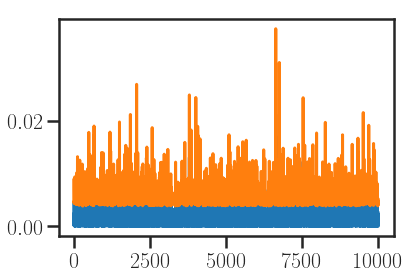

In [27]:
plt.plot(exp_v_star)
plt.plot(lbfgsb[1]*1e1);

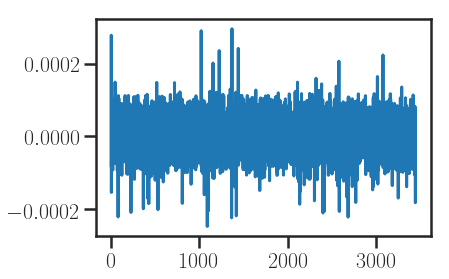

In [28]:
# Gradient w.r.t. u
plt.plot(lbfgsb[3]['grad'][:len(I_active)]);

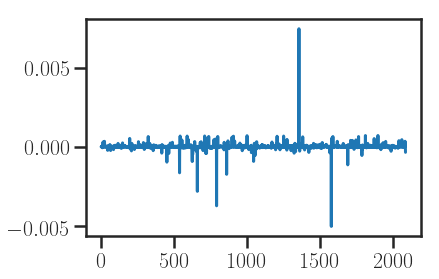

In [29]:
# Gradient w.r.t. v
plt.plot(lbfgsb[3]['grad'][len(I_active):]);

In [33]:
# sinkhorn
a_star = P_star @ np.ones(n_2)
b_star = P_star.T @ np.ones(n_1)

# screenkhorn via lbfgsb
usc_bfgs = lbfgsb[0]
vsc_bfgs = lbfgsb[1]
P_sc_bfgs = np.diag(usc_bfgs) @ K @ np.diag(vsc_bfgs)
a_sc_bfgs = P_sc_bfgs @ np.ones(n_2)
b_sc_bfgs = P_sc_bfgs.T @ np.ones(n_1)

print("sum of the marginals in sinkhorn are: %s, \t %s" %(sum(a_star), sum(b_star)))
print("\t")
print("sum of the marginals in screenkhorn are: %s, \t %s" %(sum(a_sc_bfgs), sum(b_sc_bfgs)))
print("\t")
print("Difference in sinkhorn: %s \t %s:" %(abs(1 - sum(a_star)), abs(1 - sum(b_star))))
print("\t")
print("Difference in screenkhorn: %s \t  %s:" %(abs(1 - sum(a_sc_bfgs)), abs(1 - sum(b_sc_bfgs))))
print("\t")
print("Frobenius norm of difference solution matrices %s " %np.linalg.norm(P_star - P_sc_bfgs,'fro'))
print('\t')
print("Max norm of difference solution matrices %s "  %abs(P_star.T - P_sc_bfgs.T).max())

sum of the marginals in sinkhorn are: 1.0000000000000016, 	 0.9999999999999976
	
sum of the marginals in screenkhorn are: 2.0923718433374567, 	 2.0923718433374625
	
Difference in sinkhorn: 1.5543122344752192e-15 	 2.4424906541753444e-15:
	
Difference in screenkhorn: 1.0923718433374567 	  1.0923718433374625:
	
Frobenius norm of difference solution matrices 0.00021865624915272977 
	
Max norm of difference solution matrices 5.498165459790388e-07 


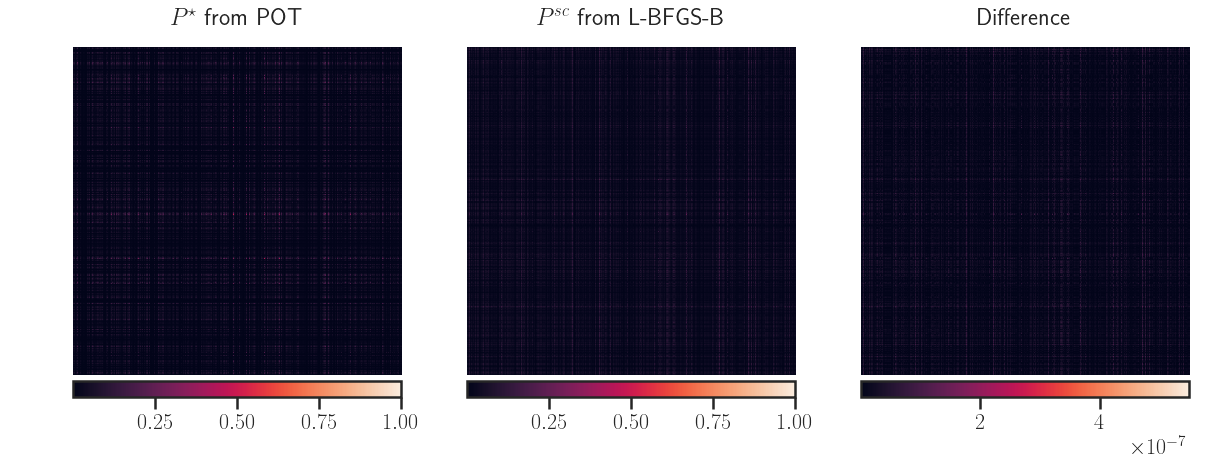

In [34]:
cb_padding = 0.005
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,20))
I1 = ax1.matshow(np.divide(P_star.T, P_star.T.max()))
ax1.set_title(r'$P^\star$ from POT')
ax1.axis('off')
fig.colorbar(I1, ax=ax1, pad=cb_padding, orientation="horizontal")
ax1.label_outer()
## 
I2 = ax2.matshow(np.divide(P_sc_bfgs.T, P_sc_bfgs.T.max()))
ax2.set_title(r'$P^{sc}$ from L-BFGS-B');
# ax2.label_outer()
ax2.axis('off')
fig.colorbar(I2, ax=ax2, pad=cb_padding, orientation="horizontal")
# 
I3 = ax3.matshow(abs(P_sc_bfgs.T - P_star.T))
ax3.set_title('Difference');
# ax3.label_outer()
ax3.axis('off');
fig.colorbar(I3, ax=ax3, pad=cb_padding, orientation="horizontal")
plt.subplots_adjust(hspace=1)